In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def plot_func(models, dataset="", unsupervised=""):
    fig, axs = plt.subplots(2, 1, figsize=(8, 16))

    for x in models:
        m = x[0]
        pool = x[1]
        c = x[2]
        for p in pool:
            spearman, pearson = [], []
            std_spearman, std_pearson = [], []
            for i in range(c):
                res = json.load(open(f"../output/{m}/{p}/{i}_to_{i+1}/test_results{dataset}{unsupervised}.json"))

                std_1 = res["stdev_cosine_spearman_test"]
                mean_1 = res["mean_cosine_spearman_test"]
                std_spearman.append((mean_1-std_1, mean_1+std_1))
                spearman.append(mean_1)

                std_2 = res["stdev_cosine_pearson_test"]
                mean_2 = res["mean_cosine_pearson_test"]
                std_pearson.append((mean_2-std_2, mean_2+std_2))
                pearson.append(mean_2)

            axs[0].plot(spearman, label=f"{m} {p}")
            if unsupervised == "":
                axs[0].fill_between(
                    np.array(list(range(c))), 
                    np.array(std_spearman)[:,0], 
                    np.array(std_spearman)[:,1], 
                    alpha=0.15
                )
            axs[0].set_xlabel("Index of hidden state")
            axs[0].set_ylabel("Spearman correlation coefficient (test set)")
            axs[0].legend()

            axs[1].plot(pearson, label=f"{m} {p}")
            if unsupervised == "":
                axs[1].fill_between(
                    np.array(list(range(c))), 
                    np.array(std_pearson)[:,0], 
                    np.array(std_pearson)[:,1], 
                    alpha=0.15
                )
            axs[1].set_xlabel("Index of hidden state")
            axs[1].set_ylabel("Pearson correlation coefficient (test set)")
            axs[1].legend()

# STSB

### Combined

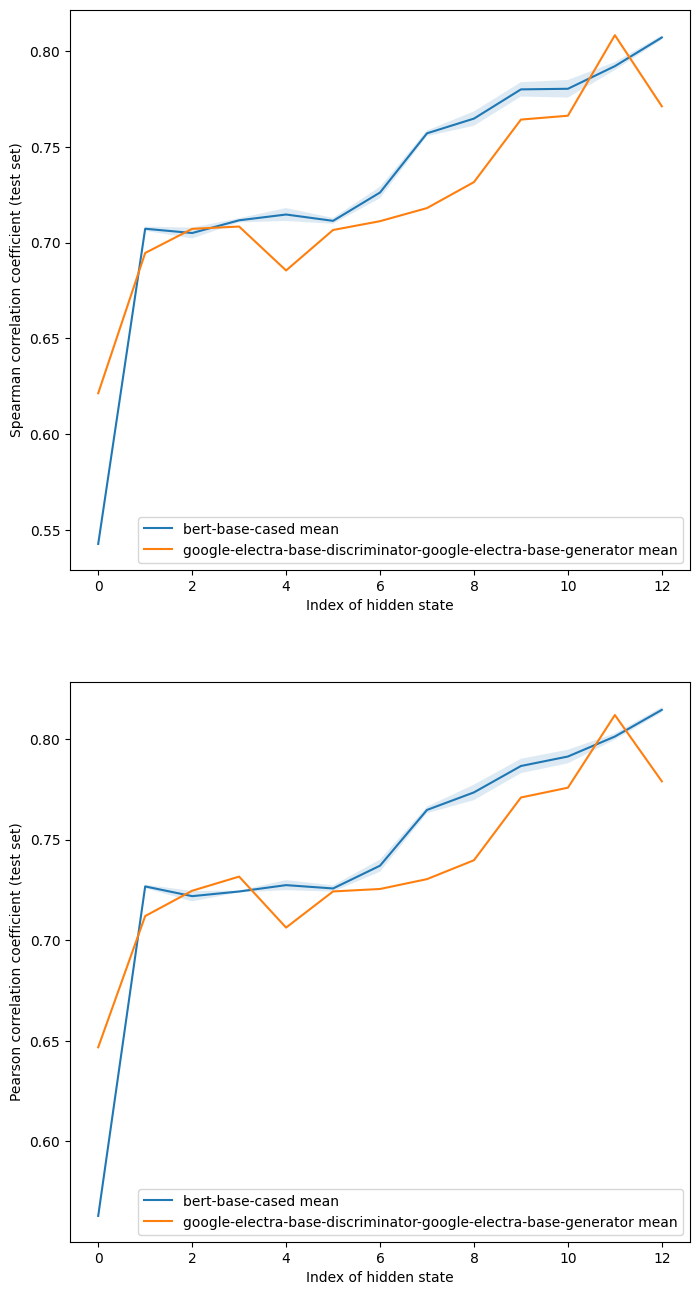

In [6]:
models = [
    ("bert-base-cased", ["mean"], 13), 
    ("google-electra-base-discriminator-google-electra-base-generator", ["mean"], 13),
]

plot_func(models)

### ELECTRA discriminator

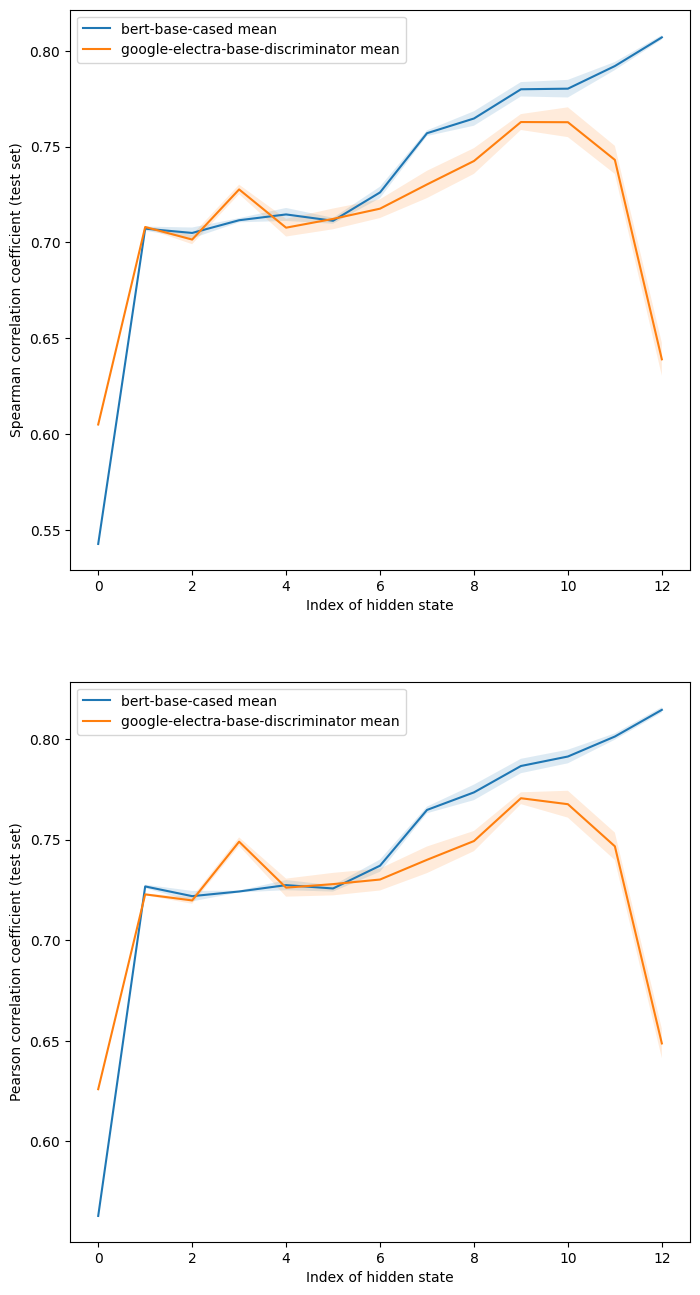

In [40]:
models = [
    ("bert-base-cased", ["mean"], 13), 
    ("google-electra-base-discriminator", ["mean"], 13),
    #("google-electra-base-generator", ["mean", "cls", "max", "weighted_mean"], 13),
]

plot_func(models)

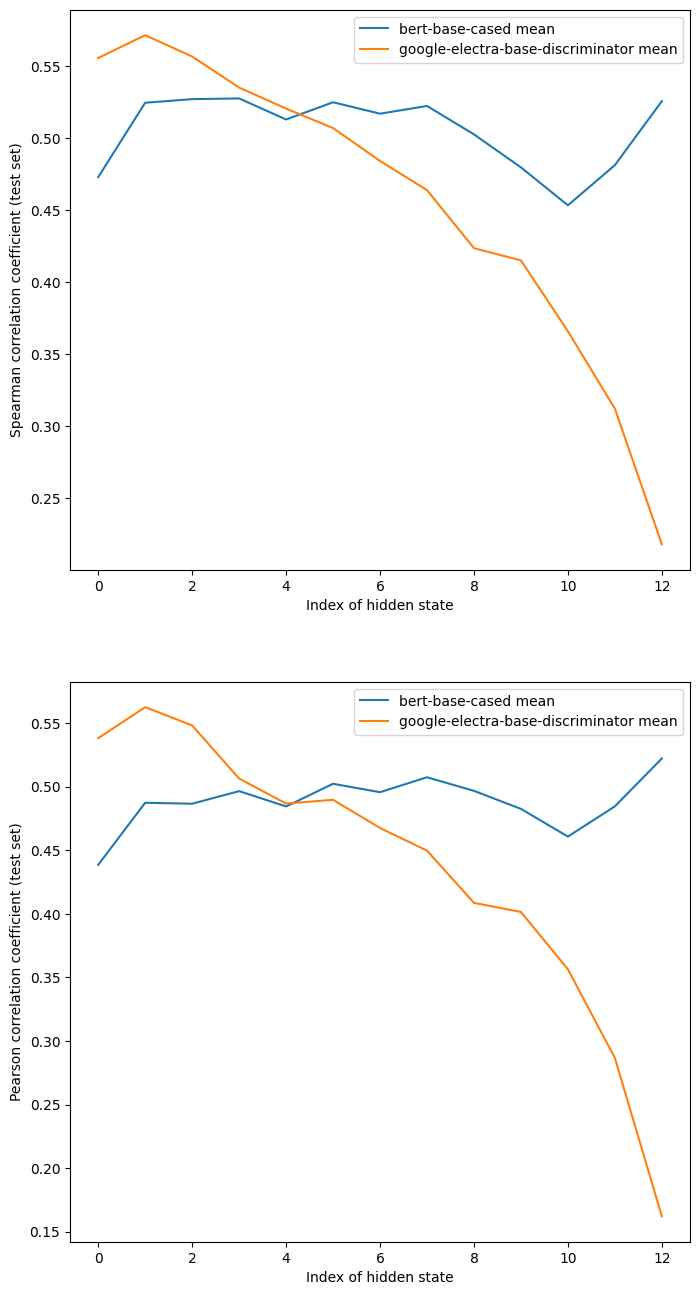

In [41]:
plot_func(models, unsupervised="_unsupervised")

 ### ELECTRA generator

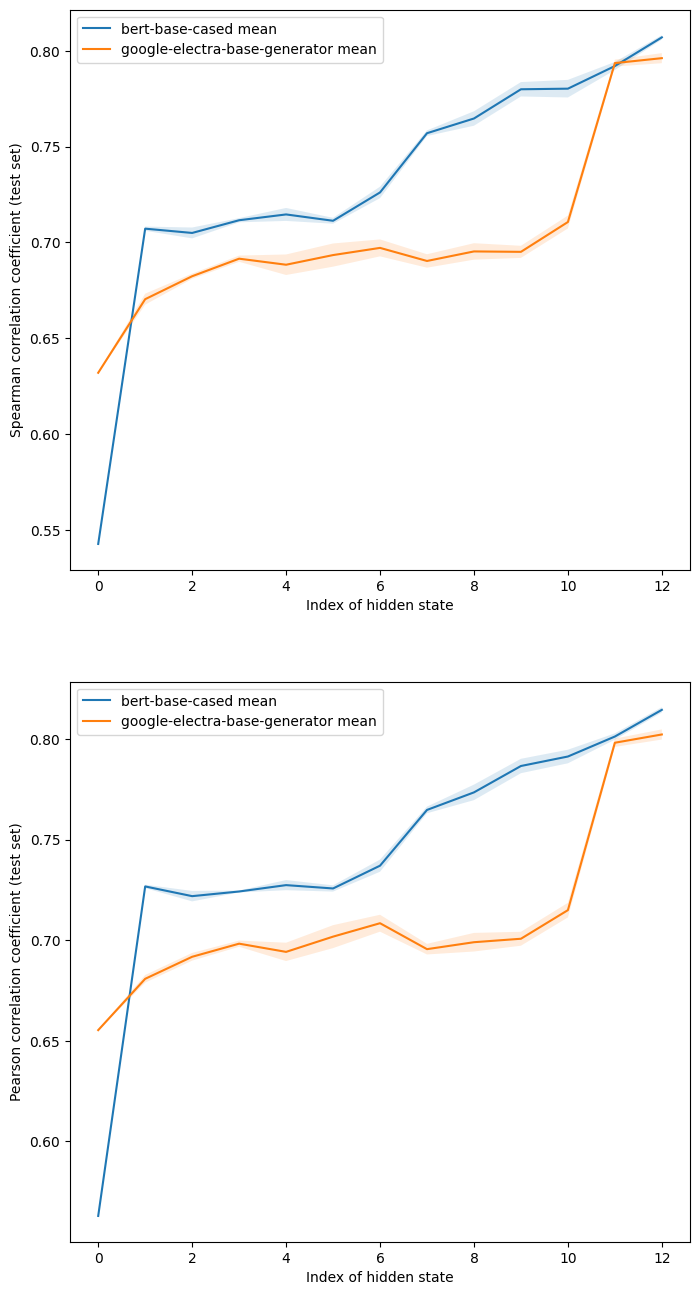

In [42]:
models = [
    ("bert-base-cased", ["mean"], 13), 
    #("google-electra-base-discriminator", ["mean"], 13),
    ("google-electra-base-generator", ["mean"], 13),
]

plot_func(models)

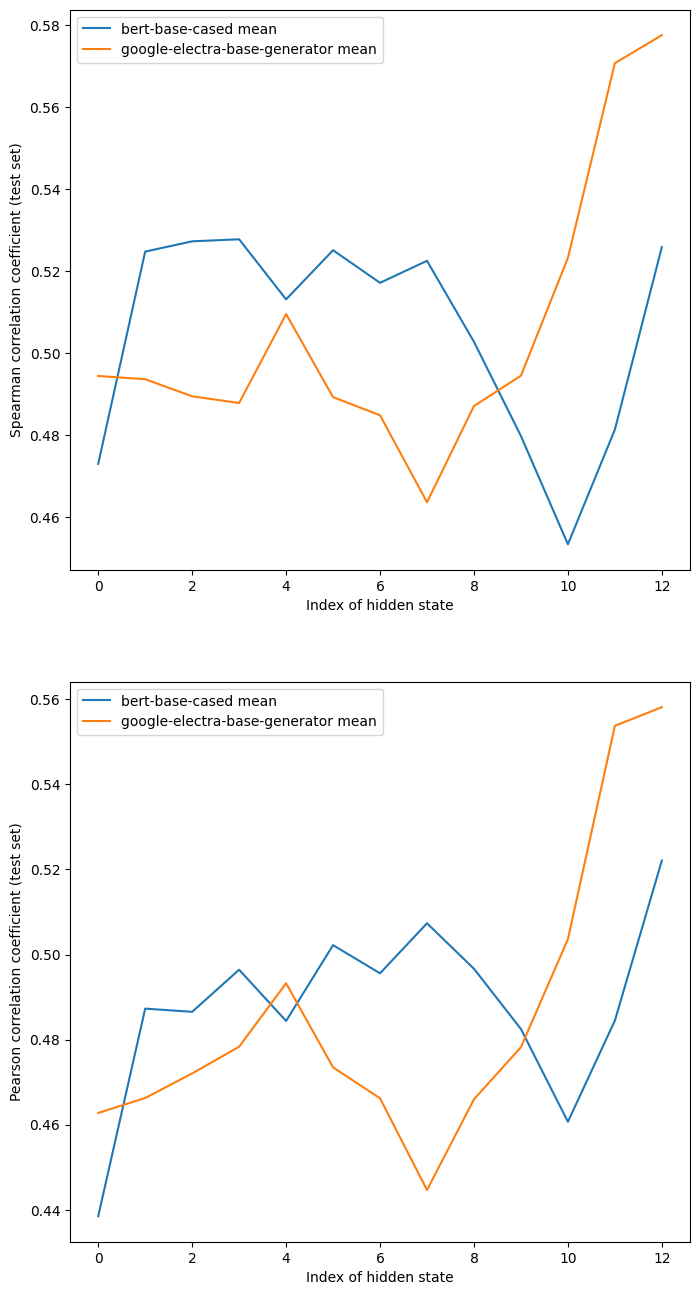

In [43]:
plot_func(models, unsupervised="_unsupervised")

# KorSTS

### ELECTRA discriminator

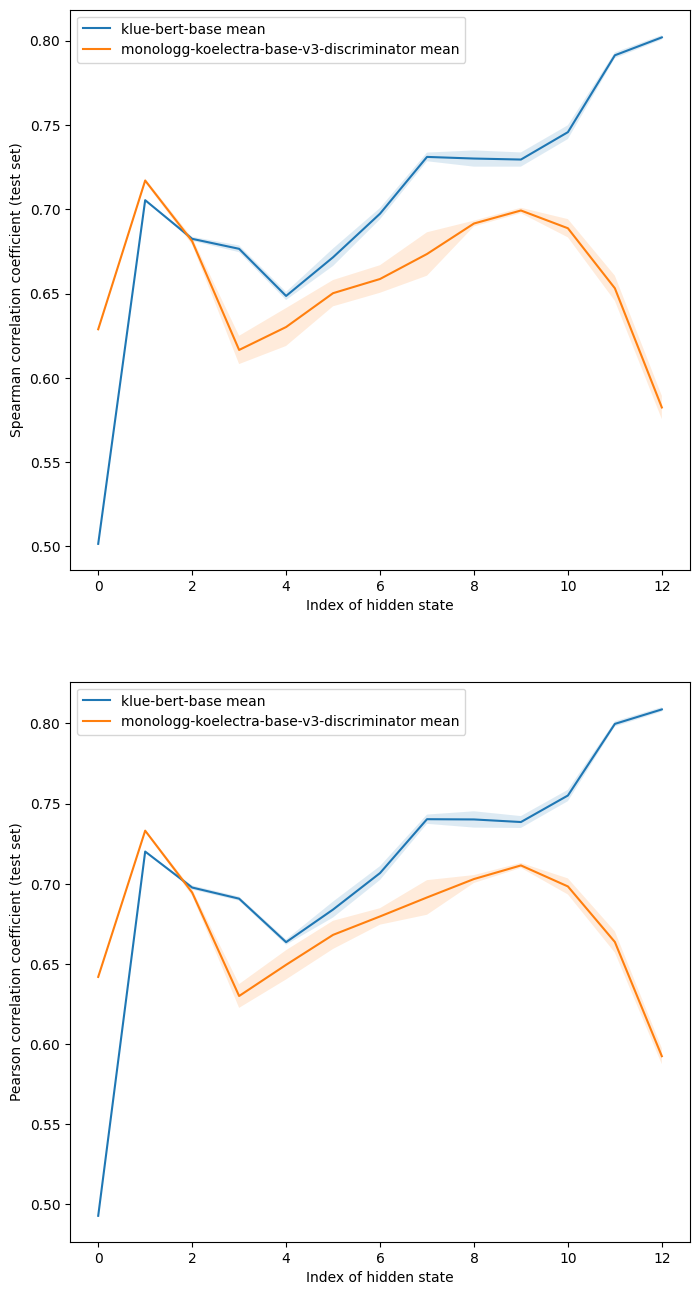

In [45]:
models = [
    ("klue-bert-base", ["mean"], 13), 
    ("monologg-koelectra-base-v3-discriminator", ["mean"], 13),
    #("monologg-koelectra-base-v3-generator", ["mean"], 13),
]

plot_func(models, dataset="_kor_sts")

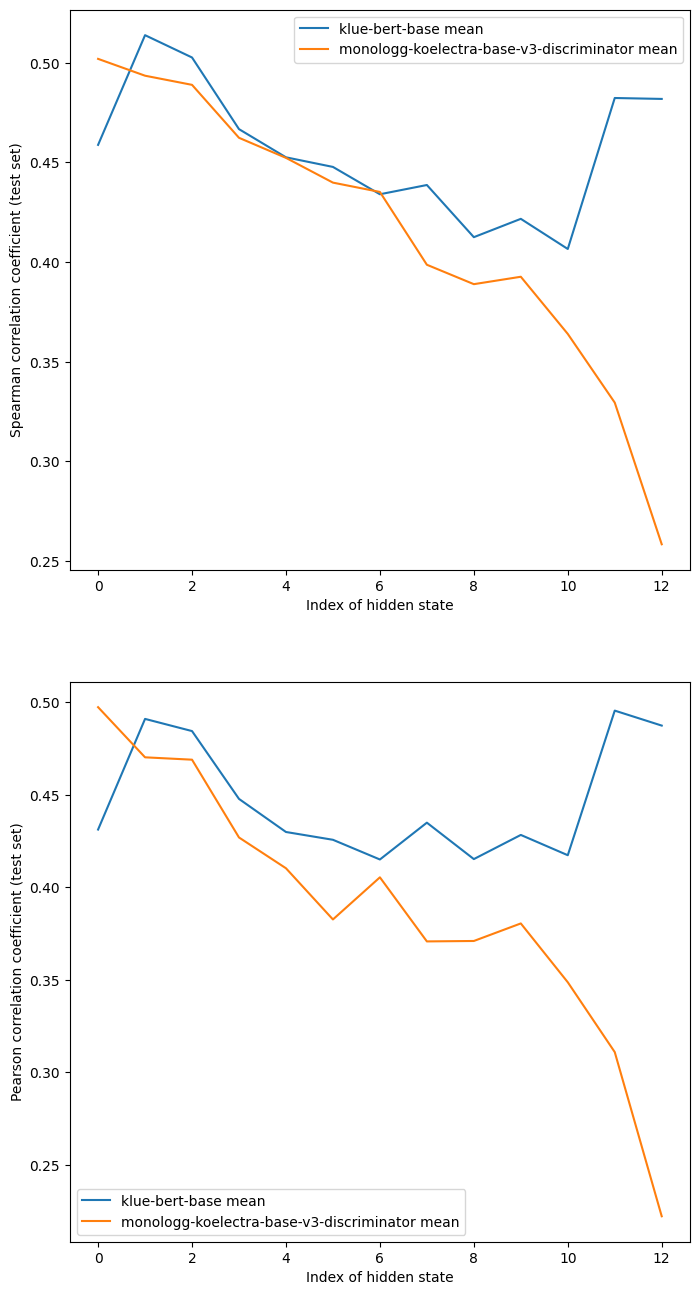

In [46]:
plot_func(models, dataset="_kor_sts", unsupervised="_unsupervised")

### ELECTRA generator

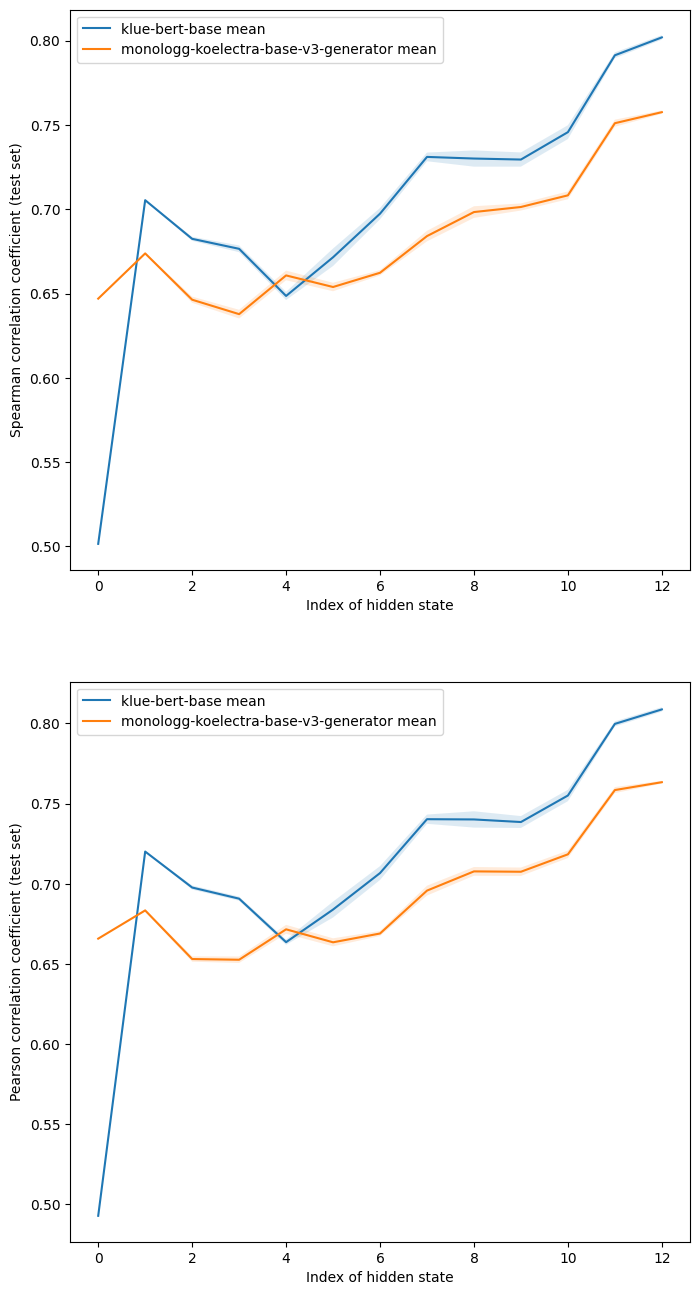

In [47]:
models = [
    ("klue-bert-base", ["mean"], 13), 
    #("monologg-koelectra-base-v3-discriminator", ["mean"], 13),
    ("monologg-koelectra-base-v3-generator", ["mean"], 13),
]

plot_func(models, dataset="_kor_sts")

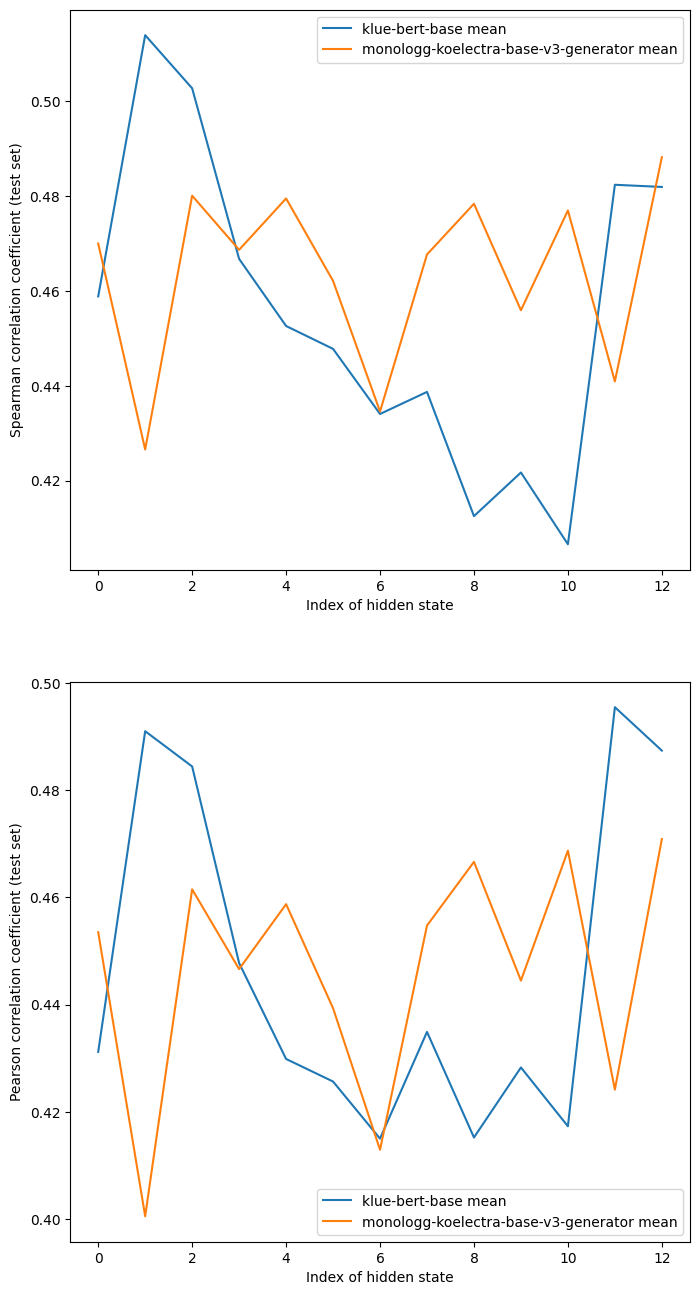

In [48]:
plot_func(models, dataset="_kor_sts", unsupervised="_unsupervised")

# German STS

### ELECTRA discriminator

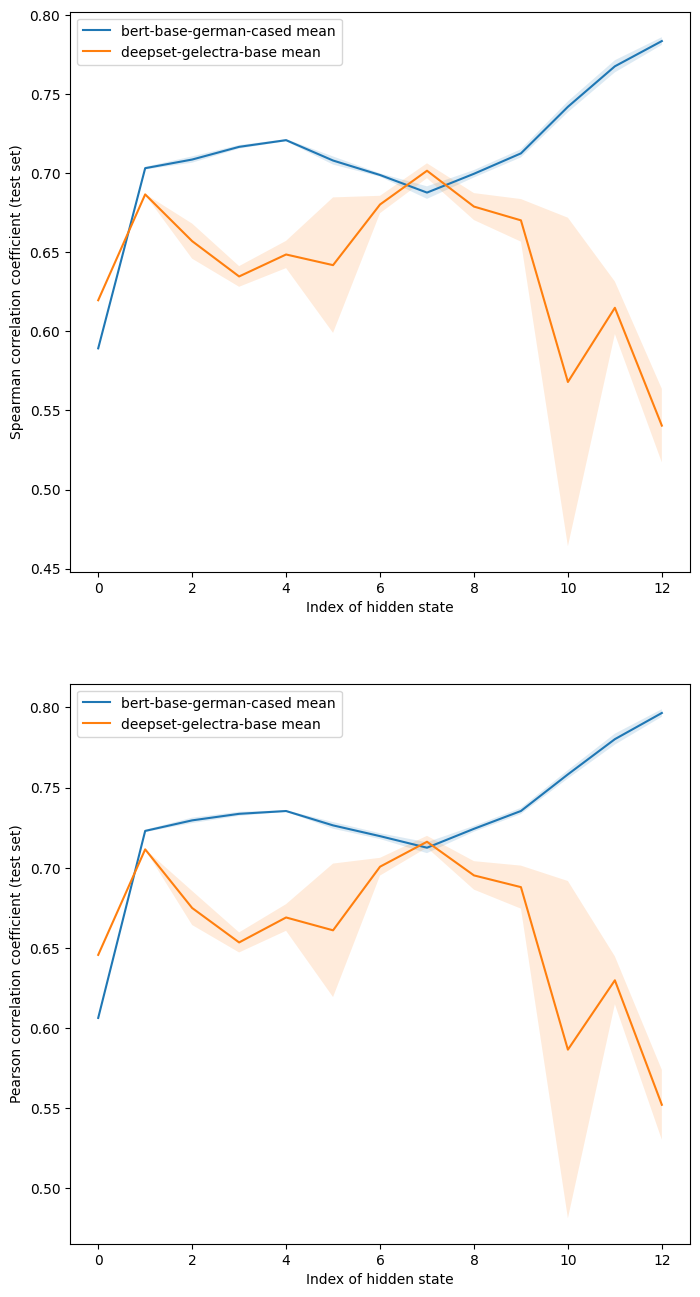

In [56]:
models = [
    ("bert-base-german-cased", ["mean"], 13), 
    ("deepset-gelectra-base", ["mean"], 13),
    #("deepset-gelectra-base-generator", ["mean"], 13),
]
plot_func(models, dataset="_german_sts")

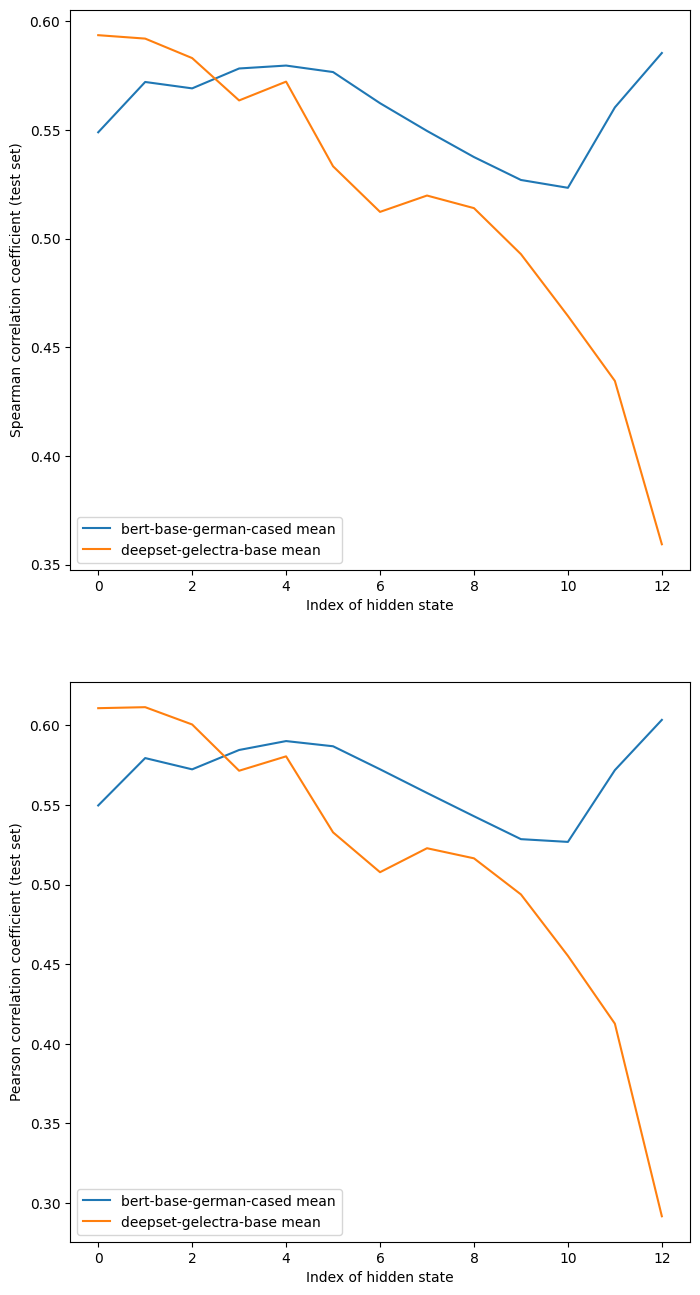

In [57]:
plot_func(models, dataset="_german_sts", unsupervised="_unsupervised")

### ELECTRA generator

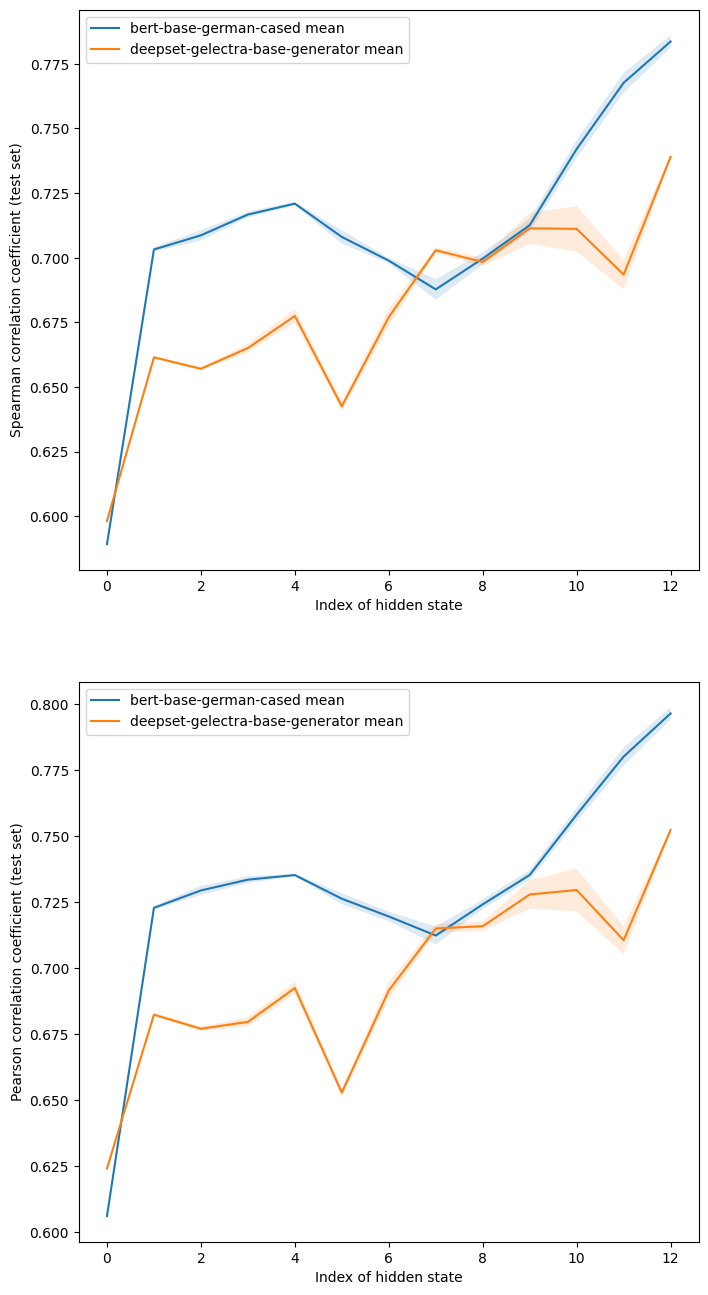

In [54]:
models = [
    ("bert-base-german-cased", ["mean"], 13), 
    #("deepset-gelectra-base", ["mean"], 13),
    ("deepset-gelectra-base-generator", ["mean"], 13),
]
plot_func(models, dataset="_german_sts")

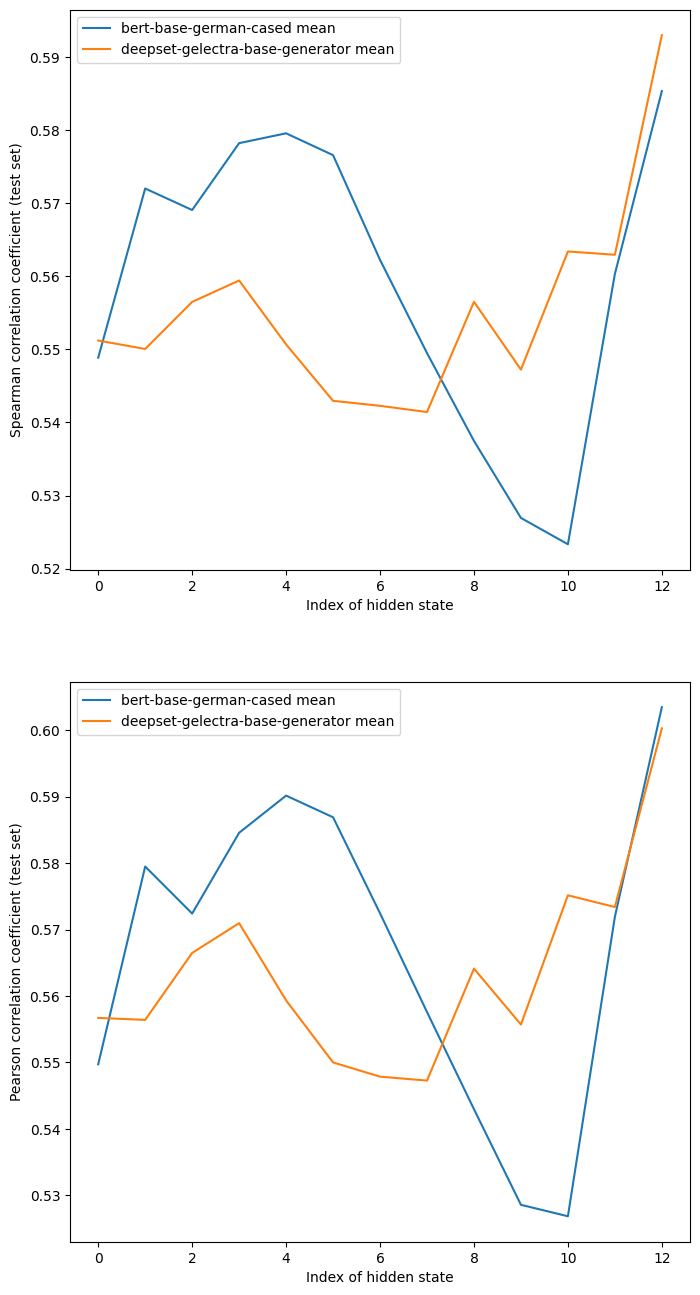

In [55]:
plot_func(models, dataset="_german_sts", unsupervised="_unsupervised")